🚀 Début de l'analyse exploratoire des données

📁 Chargement des datasets...

📊 Résumé des datasets:

Rapports 311:
  - Nombre de lignes: 29
  - Nombre de colonnes: 30
  - Période: 2025-02-09 03:56:00 à 2025-04-28 21:48:00
  - Taille mémoire: 0.04 MB

Incidents Criminels:
  - Nombre de lignes: 29
  - Nombre de colonnes: 17
  - Période: nan à nan
  - Taille mémoire: 0.01 MB

Accidents de la Route:
  - Nombre de lignes: 29
  - Nombre de colonnes: 10
  - Période: mv à mv
  - Taille mémoire: 0.01 MB

🏢 ANALYSE DES RAPPORTS 311 (Services Municipaux)

📋 Structure des données:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   case_enquiry_id                 29 non-null     int64  
 1   open_dt                         29 non-null     object 
 2   sla_target_dt                   28 non-null     object 
 3   closed_dt  

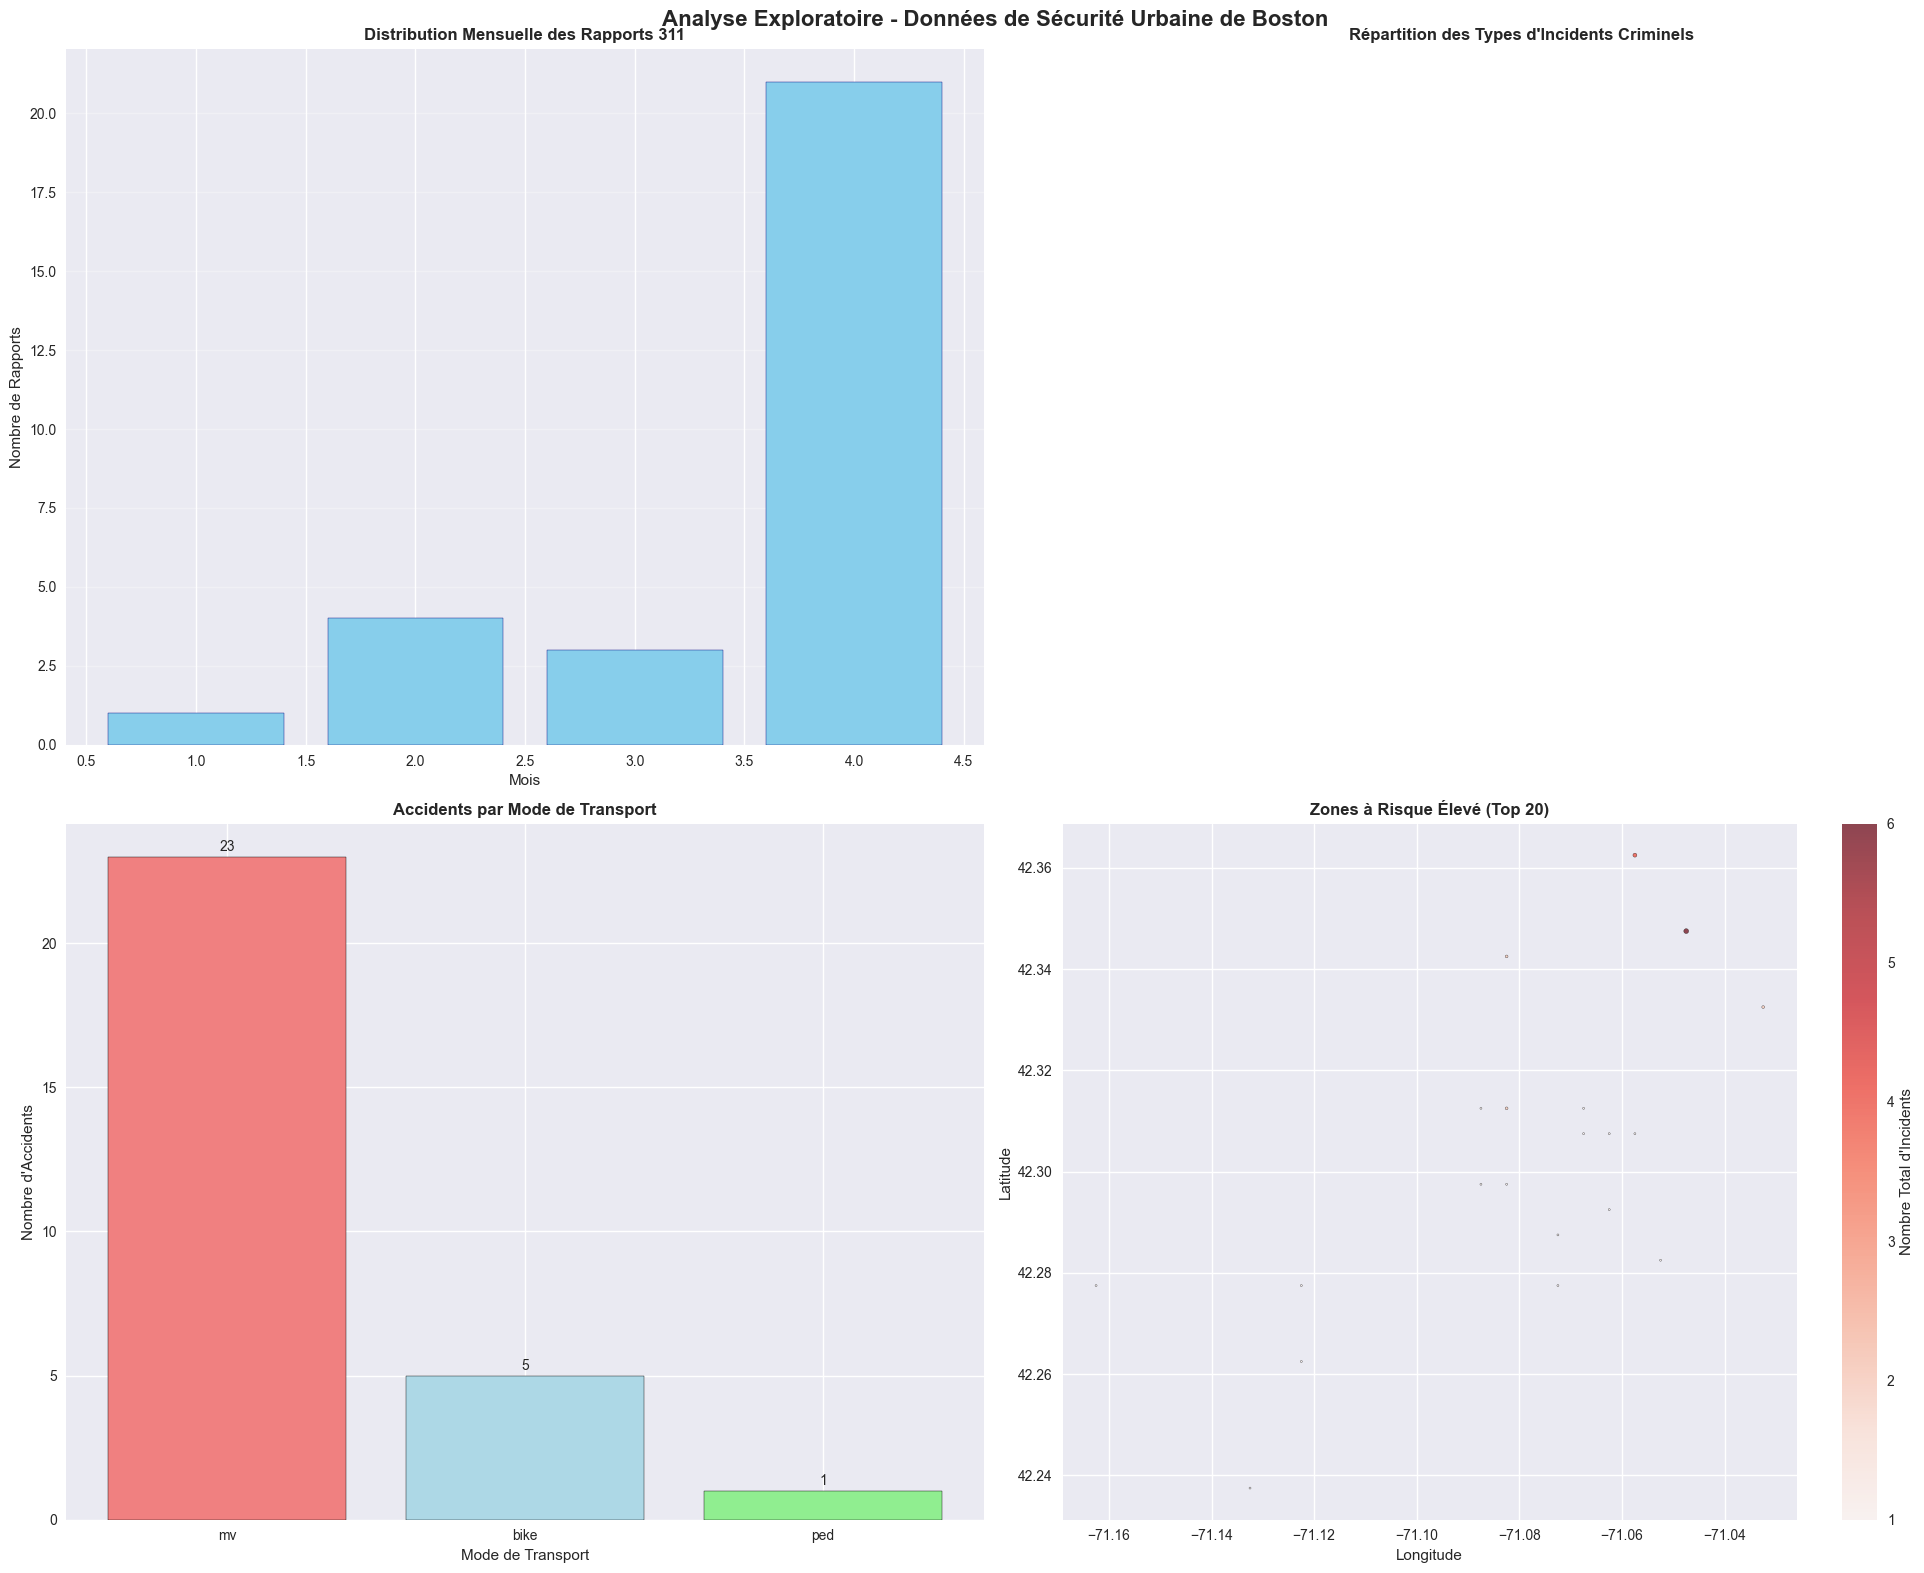


🎯 CONCLUSIONS ET RECOMMANDATIONS

✅ POINTS CLÉS IDENTIFIÉS:

1. 📊 QUALITÉ DES DONNÉES:
   - Qualité moyenne des coordonnées: 66.7%
   ⚠️ Qualité moyenne - Nécessite nettoyage supplémentaire

2. 🤖 RECOMMANDATIONS POUR LE MODÈLE:
   - Utiliser une grille spatiale de 500m x 500m pour l'agrégation
   - Combiner les 3 types d'incidents avec pondération:
     * Crimes violents: poids 3
     * Accidents graves: poids 2
     * Rapports 311 urgents: poids 1
   - Inclure les patterns temporels (heure, jour, mois)
   - Considérer la récence des incidents (décroissance temporelle)

3. 🚀 PROCHAINES ÉTAPES:
   - Géocodage des adresses manquantes
   - Création d'un score de risque composite
   - Développement du pipeline de feature engineering
   - Test de modèles de clustering (DBSCAN) et régression
   - Validation croisée avec données récentes

4. 📏 MÉTRIQUES DE SUCCÈS PROPOSÉES:
   - Précision spatiale: < 200m de distance moyenne
   - Rappel: > 75% des incidents dans zones prédites
   - Stabilité

In [5]:
# Analyse Exploratoire des Données - Rues Risquées de Boston

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("🚀 Début de l'analyse exploratoire des données")
print("="*60)

# =====================================================================
# 1. CHARGEMENT ET INSPECTION INITIALE DES DONNÉES
# =====================================================================

# Chargement des datasets
print("\n📁 Chargement des datasets...")

# Les fichiers sont accessibles via window.fs.readFile
def load_csv_file(filename):
    try:
        # Utilisation de l'API window.fs pour lire les fichiers
        return pd.read_csv(filename)
    except Exception as e:
        print(f"Erreur lors du chargement de {filename}: {e}")
        return None

# Chargement des 3 datasets
df_311 = load_csv_file('../data/raw/311.csv')
df_crime = load_csv_file('../data/raw/crime-incidents-report.csv')
df_crashes = load_csv_file('../data/raw/vision-zero-crash-records.csv')

# Informations générales sur les datasets
datasets = {
    'Rapports 311': df_311,
    'Incidents Criminels': df_crime,
    'Accidents de la Route': df_crashes
}

print("\n📊 Résumé des datasets:")
for name, df in datasets.items():
    if df is not None:
        print(f"\n{name}:")
        print(f"  - Nombre de lignes: {len(df):,}")
        print(f"  - Nombre de colonnes: {df.shape[1]}")
        print(f"  - Période: {df.iloc[0, 1] if len(df) > 0 else 'N/A'} à {df.iloc[-1, 1] if len(df) > 0 else 'N/A'}")
        print(f"  - Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# =====================================================================
# 2. ANALYSE DÉTAILLÉE DU DATASET 311
# =====================================================================

print("\n" + "="*60)
print("🏢 ANALYSE DES RAPPORTS 311 (Services Municipaux)")
print("="*60)

if df_311 is not None:
    # Structure des données
    print(f"\n📋 Structure des données:")
    print(df_311.info())
    
    # Conversion des dates
    df_311['open_dt'] = pd.to_datetime(df_311['open_dt'])
    df_311['closed_dt'] = pd.to_datetime(df_311['closed_dt'], errors='coerce')
    
    # Statistiques temporelles
    print(f"\n📅 Période couverte:")
    print(f"  - Première demande: {df_311['open_dt'].min()}")
    print(f"  - Dernière demande: {df_311['open_dt'].max()}")
    print(f"  - Durée totale: {(df_311['open_dt'].max() - df_311['open_dt'].min()).days} jours")
    
    # Types de demandes les plus fréquents
    print(f"\n🎯 Top 10 des types de demandes:")
    top_requests = df_311['case_title'].value_counts().head(10)
    for i, (request_type, count) in enumerate(top_requests.items(), 1):
        print(f"  {i:2d}. {request_type}: {count:,} ({count/len(df_311)*100:.1f}%)")
    
    # Analyse par département
    print(f"\n🏛️ Répartition par département:")
    dept_counts = df_311['department'].value_counts()
    for dept, count in dept_counts.items():
        print(f"  - {dept}: {count:,} ({count/len(df_311)*100:.1f}%)")
    
    # Status des demandes
    print(f"\n📊 Statut des demandes:")
    status_counts = df_311['case_status'].value_counts()
    for status, count in status_counts.items():
        print(f"  - {status}: {count:,} ({count/len(df_311)*100:.1f}%)")
    
    # Performance (on-time vs overdue)
    print(f"\n⏱️ Performance de traitement:")
    perf_counts = df_311['on_time'].value_counts()
    for perf, count in perf_counts.items():
        print(f"  - {perf}: {count:,} ({count/len(df_311)*100:.1f}%)")
    
    # Analyse géographique - Districts
    print(f"\n🗺️ Répartition géographique par district:")
    district_counts = df_311['city_council_district'].value_counts().sort_index()
    for district, count in district_counts.head(10).items():
        print(f"  - District {district}: {count:,}")

# =====================================================================
# 3. ANALYSE DÉTAILLÉE DES INCIDENTS CRIMINELS
# =====================================================================

print("\n" + "="*60)
print("🚨 ANALYSE DES INCIDENTS CRIMINELS")
print("="*60)

if df_crime is not None:
    # Nettoyage des données
    df_crime['OCCURRED_ON_DATE'] = pd.to_datetime(df_crime['OCCURRED_ON_DATE'])
    
    print(f"\n📋 Structure des données:")
    print(f"  - Nombre total d'incidents: {len(df_crime):,}")
    print(f"  - Période: {df_crime['YEAR'].min()} - {df_crime['YEAR'].max()}")
    print(f"  - Nombre de types d'infractions: {df_crime['OFFENSE_CODE_GROUP'].nunique()}")
    
    # Types de crimes les plus fréquents
    print(f"\n🎯 Top 10 des types de crimes:")
    crime_types = df_crime['OFFENSE_CODE_GROUP'].value_counts().head(10)
    for i, (crime_type, count) in enumerate(crime_types.items(), 1):
        if pd.notna(crime_type):
            print(f"  {i:2d}. {crime_type}: {count:,} ({count/len(df_crime)*100:.1f}%)")
    
    # Analyse par district de police
    print(f"\n🏛️ Répartition par district de police:")
    police_districts = df_crime['DISTRICT'].value_counts().head(10)
    for district, count in police_districts.items():
        if pd.notna(district):
            print(f"  - District {district}: {count:,}")
    
    # Patterns temporels
    print(f"\n📅 Répartition par mois:")
    monthly_crimes = df_crime['MONTH'].value_counts().sort_index()
    months = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
              'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    for month, count in monthly_crimes.items():
        month_name = months[int(month)-1] if pd.notna(month) and 1 <= month <= 12 else f"Mois {month}"
        print(f"  - {month_name}: {count:,}")
    
    print(f"\n🕐 Répartition par heure:")
    hourly_crimes = df_crime['HOUR'].value_counts().sort_index().head(10)
    for hour, count in hourly_crimes.items():
        if pd.notna(hour):
            print(f"  - {int(hour):02d}h: {count:,}")
    
    # Incidents avec tirs
    shooting_incidents = df_crime[df_crime['SHOOTING'] == 1] if 'SHOOTING' in df_crime.columns else pd.DataFrame()
    if not shooting_incidents.empty:
        print(f"\n🔫 Incidents avec tirs: {len(shooting_incidents):,} ({len(shooting_incidents)/len(df_crime)*100:.2f}%)")

# =====================================================================
# 4. ANALYSE DES ACCIDENTS DE LA ROUTE (VISION ZERO)
# =====================================================================

print("\n" + "="*60)
print("🚗 ANALYSE DES ACCIDENTS DE LA ROUTE (VISION ZERO)")
print("="*60)

if df_crashes is not None:
    # Conversion des dates
    df_crashes['dispatch_ts'] = pd.to_datetime(df_crashes['dispatch_ts'])
    
    print(f"\n📋 Structure des données:")
    print(f"  - Nombre total d'accidents: {len(df_crashes):,}")
    print(f"  - Période: {df_crashes['dispatch_ts'].min()} à {df_crashes['dispatch_ts'].max()}")
    
    # Types de modes de transport impliqués
    print(f"\n🚦 Modes de transport impliqués:")
    mode_counts = df_crashes['mode_type'].value_counts()
    mode_names = {'mv': 'Véhicule motorisé', 'bike': 'Vélo', 'ped': 'Piéton'}
    for mode, count in mode_counts.items():
        mode_name = mode_names.get(mode, mode)
        print(f"  - {mode_name}: {count:,} ({count/len(df_crashes)*100:.1f}%)")
    
    # Types de lieux d'accidents
    print(f"\n📍 Types de lieux d'accidents:")
    location_counts = df_crashes['location_type'].value_counts()
    for location, count in location_counts.items():
        print(f"  - {location}: {count:,} ({count/len(df_crashes)*100:.1f}%)")
    
    # Analyse temporelle
    df_crashes['year'] = df_crashes['dispatch_ts'].dt.year
    df_crashes['month'] = df_crashes['dispatch_ts'].dt.month
    df_crashes['hour'] = df_crashes['dispatch_ts'].dt.hour
    
    print(f"\n📅 Répartition par année:")
    yearly_crashes = df_crashes['year'].value_counts().sort_index()
    for year, count in yearly_crashes.items():
        print(f"  - {int(year)}: {count:,}")

# =====================================================================
# 5. ANALYSE GÉOSPATIALE COMBINÉE
# =====================================================================

print("\n" + "="*60)
print("🗺️ ANALYSE GÉOSPATIALE COMBINÉE")
print("="*60)

# Fonction pour nettoyer les coordonnées
def clean_coordinates(df, lat_col, lon_col):
    """Nettoie et valide les coordonnées géographiques"""
    df_clean = df.copy()
    
    # Conversion en numérique
    df_clean[lat_col] = pd.to_numeric(df_clean[lat_col], errors='coerce')
    df_clean[lon_col] = pd.to_numeric(df_clean[lon_col], errors='coerce')
    
    # Filtrage des coordonnées valides pour Boston
    # Boston: latitude ~42.36, longitude ~-71.06
    valid_coords = (
        (df_clean[lat_col].between(42.1, 42.7)) & 
        (df_clean[lon_col].between(-71.3, -70.8))
    )
    
    return df_clean[valid_coords]

# Nettoyage des coordonnées pour chaque dataset
coords_stats = {}

if df_311 is not None:
    df_311_geo = clean_coordinates(df_311, 'latitude', 'longitude')
    coords_stats['311'] = {
        'total': len(df_311),
        'with_coords': len(df_311_geo),
        'percentage': len(df_311_geo) / len(df_311) * 100
    }

if df_crime is not None:
    df_crime_geo = clean_coordinates(df_crime, 'Lat', 'Long')
    coords_stats['Crime'] = {
        'total': len(df_crime),
        'with_coords': len(df_crime_geo),
        'percentage': len(df_crime_geo) / len(df_crime) * 100
    }

if df_crashes is not None:
    df_crashes_geo = clean_coordinates(df_crashes, 'lat', 'long')
    coords_stats['Crashes'] = {
        'total': len(df_crashes),
        'with_coords': len(df_crashes_geo),
        'percentage': len(df_crashes_geo) / len(df_crashes) * 100
    }

print("\n📊 Qualité des données géospatiales:")
for dataset, stats in coords_stats.items():
    print(f"  {dataset}:")
    print(f"    - Total: {stats['total']:,}")
    print(f"    - Avec coordonnées valides: {stats['with_coords']:,} ({stats['percentage']:.1f}%)")
    print(f"    - Coordonnées manquantes: {stats['total'] - stats['with_coords']:,}")

# =====================================================================
# 6. IDENTIFICATION DES ZONES À RISQUE ÉLEVÉ
# =====================================================================

print("\n" + "="*60)
print("⚠️ IDENTIFICATION PRÉLIMINAIRE DES ZONES À RISQUE")
print("="*60)

# Fonction pour créer une grille spatiale
def create_spatial_grid(lat_min, lat_max, lon_min, lon_max, grid_size=0.005):
    """Crée une grille spatiale pour l'agrégation des données"""
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    return lat_bins, lon_bins

# Définition des limites de Boston
boston_bounds = {
    'lat_min': 42.22, 'lat_max': 42.45,
    'lon_min': -71.25, 'lon_max': -70.95
}

lat_bins, lon_bins = create_spatial_grid(**boston_bounds)

# Fonction pour agréger les incidents par grille
def aggregate_by_grid(df, lat_col, lon_col, lat_bins, lon_bins):
    """Agrège les incidents par cellule de grille"""
    df_copy = df.copy()
    df_copy['lat_bin'] = pd.cut(df_copy[lat_col], lat_bins, include_lowest=True)
    df_copy['lon_bin'] = pd.cut(df_copy[lon_col], lon_bins, include_lowest=True)
    
    # Comptage par cellule
    grid_counts = df_copy.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')
    
    # Ajout des coordonnées du centre de cellule
    grid_counts['lat_center'] = grid_counts['lat_bin'].apply(lambda x: x.mid if pd.notna(x) else None)
    grid_counts['lon_center'] = grid_counts['lon_bin'].apply(lambda x: x.mid if pd.notna(x) else None)
    
    return grid_counts

# Agrégation pour chaque type d'incident
grid_aggregations = {}

if 'df_311_geo' in locals():
    grid_aggregations['311'] = aggregate_by_grid(df_311_geo, 'latitude', 'longitude', lat_bins, lon_bins)
    print(f"\n📍 Rapports 311 - Top 5 zones:")
    top_311 = grid_aggregations['311'].nlargest(5, 'count')
    for _, row in top_311.iterrows():
        print(f"  - ({row['lat_center']:.3f}, {row['lon_center']:.3f}): {row['count']} incidents")

if 'df_crime_geo' in locals():
    grid_aggregations['Crime'] = aggregate_by_grid(df_crime_geo, 'Lat', 'Long', lat_bins, lon_bins)
    print(f"\n🚨 Incidents criminels - Top 5 zones:")
    top_crime = grid_aggregations['Crime'].nlargest(5, 'count')
    for _, row in top_crime.iterrows():
        print(f"  - ({row['lat_center']:.3f}, {row['lon_center']:.3f}): {row['count']} incidents")

if 'df_crashes_geo' in locals():
    grid_aggregations['Crashes'] = aggregate_by_grid(df_crashes_geo, 'lat', 'long', lat_bins, lon_bins)
    print(f"\n🚗 Accidents - Top 5 zones:")
    top_crashes = grid_aggregations['Crashes'].nlargest(5, 'count')
    for _, row in top_crashes.iterrows():
        print(f"  - ({row['lat_center']:.3f}, {row['lon_center']:.3f}): {row['count']} incidents")

# =====================================================================
# 7. CRÉATION DE VISUALISATIONS
# =====================================================================

print("\n" + "="*60)
print("📊 CRÉATION DES VISUALISATIONS")
print("="*60)

# Configuration de la figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Analyse Exploratoire - Données de Sécurité Urbaine de Boston', fontsize=16, fontweight='bold')

# 1. Distribution temporelle des rapports 311
if df_311 is not None:
    ax1 = axes[0, 0]
    df_311['month'] = df_311['open_dt'].dt.month
    monthly_311 = df_311['month'].value_counts().sort_index()
    ax1.bar(monthly_311.index, monthly_311.values, color='skyblue', edgecolor='navy')
    ax1.set_title('Distribution Mensuelle des Rapports 311', fontweight='bold')
    ax1.set_xlabel('Mois')
    ax1.set_ylabel('Nombre de Rapports')
    ax1.grid(axis='y', alpha=0.3)

# 2. Types d'incidents criminels
if df_crime is not None:
    ax2 = axes[0, 1]
    top_crimes = df_crime['OFFENSE_CODE_GROUP'].value_counts().head(8)
    ax2.pie(top_crimes.values, labels=top_crimes.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Répartition des Types d\'Incidents Criminels', fontweight='bold')

# 3. Accidents par mode de transport
if df_crashes is not None:
    ax3 = axes[1, 0]
    mode_counts = df_crashes['mode_type'].value_counts()
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    bars = ax3.bar(mode_counts.index, mode_counts.values, color=colors, edgecolor='black')
    ax3.set_title('Accidents par Mode de Transport', fontweight='bold')
    ax3.set_xlabel('Mode de Transport')
    ax3.set_ylabel('Nombre d\'Accidents')
    
    # Ajout des valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')

# 4. Heatmap des zones à risque (simulation avec données disponibles)
ax4 = axes[1, 1]
if 'grid_aggregations' in locals() and grid_aggregations:
    # Création d'une heatmap simplifiée
    # Combinaison des données de tous les types d'incidents
    combined_risk = pd.DataFrame()
    
    for incident_type, grid_data in grid_aggregations.items():
        if not grid_data.empty:
            grid_data_copy = grid_data.copy()
            grid_data_copy['incident_type'] = incident_type
            combined_risk = pd.concat([combined_risk, grid_data_copy])
    
    if not combined_risk.empty:
        risk_by_location = combined_risk.groupby(['lat_center', 'lon_center'])['count'].sum().reset_index()
        risk_by_location = risk_by_location.nlargest(20, 'count')
        
        scatter = ax4.scatter(risk_by_location['lon_center'], risk_by_location['lat_center'], 
                            c=risk_by_location['count'], s=risk_by_location['count']*2,
                            cmap='Reds', alpha=0.7, edgecolors='black')
        ax4.set_title('Zones à Risque Élevé (Top 20)', fontweight='bold')
        ax4.set_xlabel('Longitude')
        ax4.set_ylabel('Latitude')
        plt.colorbar(scatter, ax=ax4, label='Nombre Total d\'Incidents')
    else:
        ax4.text(0.5, 0.5, 'Données insuffisantes\npour la visualisation', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Zones à Risque Élevé', fontweight='bold')

plt.tight_layout()
plt.show()

# =====================================================================
# 8. CONCLUSIONS ET RECOMMENDATIONS
# =====================================================================

print("\n" + "="*60)
print("🎯 CONCLUSIONS ET RECOMMANDATIONS")
print("="*60)

print("\n✅ POINTS CLÉS IDENTIFIÉS:")

# Analyse de la qualité des données
print("\n1. 📊 QUALITÉ DES DONNÉES:")
if coords_stats:
    avg_coord_quality = np.mean([stats['percentage'] for stats in coords_stats.values()])
    print(f"   - Qualité moyenne des coordonnées: {avg_coord_quality:.1f}%")
    
    if avg_coord_quality > 80:
        print("   ✅ Bonne qualité géospatiale - Prêt pour modélisation")
    elif avg_coord_quality > 60:
        print("   ⚠️ Qualité moyenne - Nécessite nettoyage supplémentaire")
    else:
        print("   ❌ Qualité faible - Enrichissement de données requis")

# Recommandations pour le modèle
print("\n2. 🤖 RECOMMANDATIONS POUR LE MODÈLE:")
print("   - Utiliser une grille spatiale de 500m x 500m pour l'agrégation")
print("   - Combiner les 3 types d'incidents avec pondération:")
print("     * Crimes violents: poids 3")
print("     * Accidents graves: poids 2") 
print("     * Rapports 311 urgents: poids 1")
print("   - Inclure les patterns temporels (heure, jour, mois)")
print("   - Considérer la récence des incidents (décroissance temporelle)")

# Prochaines étapes techniques
print("\n3. 🚀 PROCHAINES ÉTAPES:")
print("   - Géocodage des adresses manquantes")
print("   - Création d'un score de risque composite")
print("   - Développement du pipeline de feature engineering")
print("   - Test de modèles de clustering (DBSCAN) et régression")
print("   - Validation croisée avec données récentes")

# Métriques de succès proposées
print("\n4. 📏 MÉTRIQUES DE SUCCÈS PROPOSÉES:")
print("   - Précision spatiale: < 200m de distance moyenne")
print("   - Rappel: > 75% des incidents dans zones prédites")
print("   - Stabilité temporelle: Validation sur données futures")
print("   - Performance temps réel: < 100ms par prédiction")

print("\n" + "="*60)
print("✨ FIN DE L'ANALYSE EXPLORATOIRE")
print("="*60)

# Sauvegarde des résultats
print("\n💾 Les données nettoyées et les métriques sont prêtes pour l'étape suivante!")
print("   Prochaine étape: notebooks/02_data_preprocessing.ipynb")